In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import cv2
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import time 
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

Load Dataset

In [3]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


Get image shape 96x96x3

In [4]:
train_dir = '../input/histopathologic-cancer-detection/train'
file = os.listdir(train_dir)[0]

img = Image.open(os.path.join(train_dir, file))
arr = np.array(img)
print(arr.shape)

(96, 96, 3)


In [5]:
test_dir = '../input/histopathologic-cancer-detection/test'
file = os.listdir(test_dir)[0]

img = Image.open(os.path.join(test_dir, file))
arr = np.array(img)
print(arr.shape)

(96, 96, 3)


In [6]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


In [7]:
print(train_labels)

                                              id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]


Clean up- Check duplicate ids

In [8]:
# Check duplicate rows 
dup_rows = train_labels[train_labels.duplicated(keep=False)]
print("Duplicate rows:", len(dup_rows))

Duplicate rows: 0


When the Label is 1 -> positive and when the label is 0 -> negative

In [9]:
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/" # training data is stored in this folder
df_positive = train_labels.loc[train_labels['label']==1]['id'].values   
df_negative = train_labels.loc[train_labels['label']==0]['id'].values       

print('Positive ids')
print(df_positive[0:3],'\n')

print('Negative ids')
print(df_negative[0:3])

Positive ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f'] 

Negative ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08']


Visulize Image

In [10]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

Sampling- use 4000 positive and 4000 negative cases

In [15]:
# Number of samples in each class
SAMPLE_SIZE = 4000


# Use 4000 positive and negative examples
df_negatives = train_labels[train_labels['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = train_labels[train_labels['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(8000, 2)

Data Pre-processing

In [16]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [17]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_dir, transform=transforms_train)

Set Batch size = 128

In [18]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

I don't have a GPU, so I pick a sub_sample = 20000 for testing

In [19]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")



# ----- choose a smaller sample in memory -----
K = 20000  # pick how many you want
sample_sub_small = sample_sub.sample(n=K, random_state=42).sort_values("id").reset_index(drop=True)

# prepare the test loader
test_data = CreateDataset(df_data=sample_sub_small, data_dir=test_dir, transform=transforms_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Model Architecture

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

Training 

In [21]:
model = CNN()
print(model)

# # Move model to GPU if available
# if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [22]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [23]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

Choose a small n_epochs due to no GPU

In [26]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        #print(loss)
    
    # validate the model #
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1).float()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
   
    # Early Stopping #
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.353825 | Validation Loss: 0.310900 | Validation AUC: 0.9537
Validation loss decreased (inf --> 0.310900).
Epoch: 2 | Training Loss: 0.338187 | Validation Loss: 0.301035 | Validation AUC: 0.9503
Validation loss decreased (0.310900 --> 0.301035).
Epoch: 3 | Training Loss: 0.338003 | Validation Loss: 0.315924 | Validation AUC: 0.9491
Epoch: 4 | Training Loss: 0.329177 | Validation Loss: 0.303723 | Validation AUC: 0.9492
Epoch: 5 | Training Loss: 0.325482 | Validation Loss: 0.325051 | Validation AUC: 0.9491
Epoch: 6 | Training Loss: 0.322901 | Validation Loss: 0.313867 | Validation AUC: 0.9482
Epoch: 7 | Training Loss: 0.314964 | Validation Loss: 0.287333 | Validation AUC: 0.9486
Validation loss decreased (0.301035 --> 0.287333).
Epoch: 8 | Training Loss: 0.311139 | Validation Loss: 0.325384 | Validation AUC: 0.9460
Epoch: 9 | Training Loss: 0.316467 | Validation Loss: 0.302632 | Validation AUC: 0.9460
Epoch: 10 | Training Loss: 0.310248 | Validation Loss: 0.297

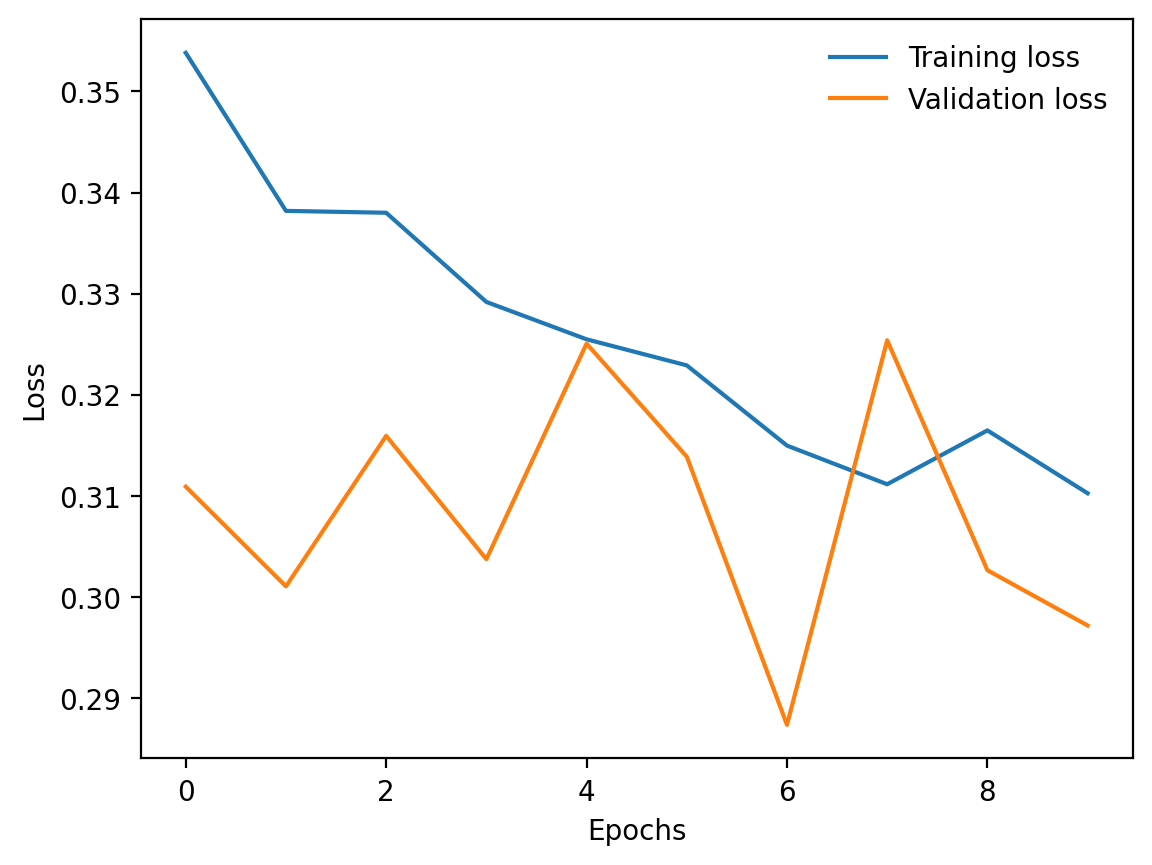

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

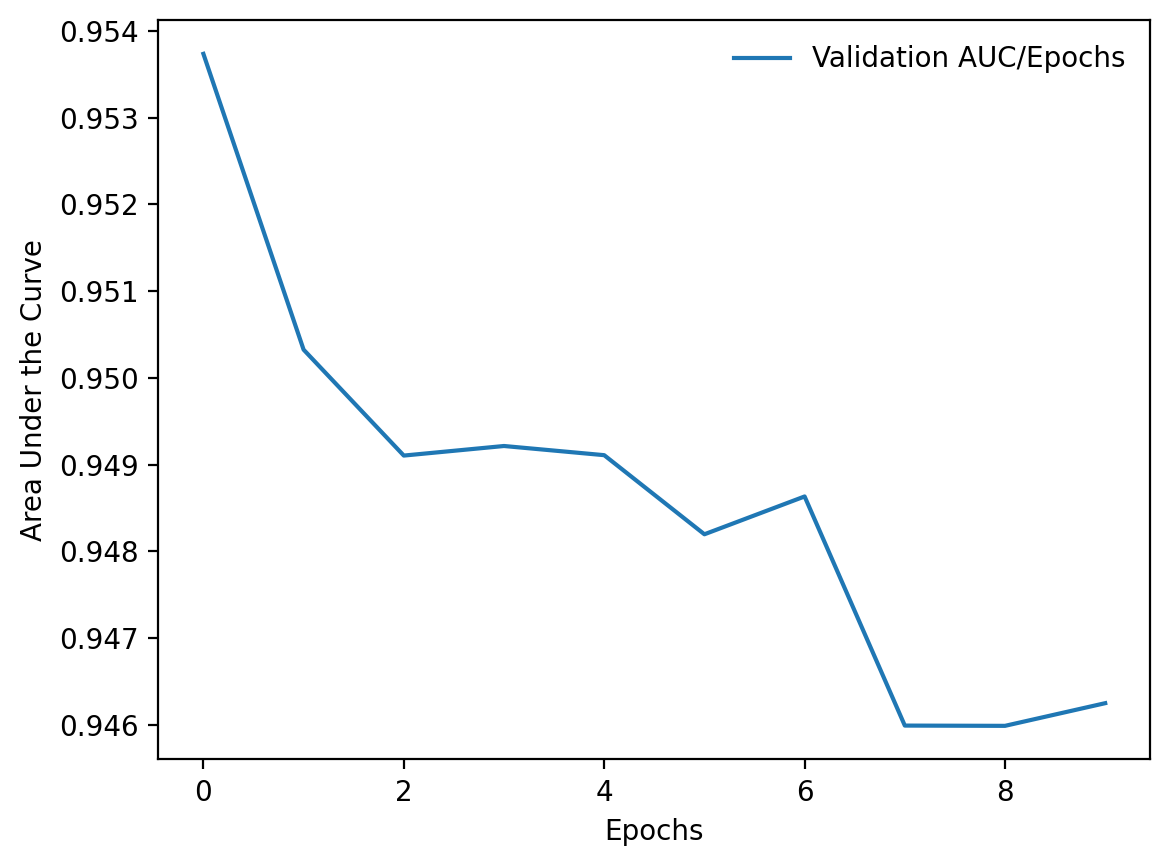

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

Best Val AUC: 0.9537 (epoch 1) 

Best Val Loss: 0.2873 (epoch 7) 

In [29]:
# Turn off gradients
model.eval()

preds = []
target_all = []
for batch_i, (data, target) in enumerate(test_loader):
    #data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        if i >= 0.5:
            preds.append(1)
        else:
            preds.append(0)

    for i in target:
        target_all.append(int(i.numpy()))

# Create Submission file        
sample_sub_small['label'] = preds

count = 0
for i in range(len(preds)):
    if preds[i] == target_all[i]:
        count += 1
print(count)

accuracy = float(count) / len(preds)
print(accuracy)

11730
0.5865


Hypertuning- change learning rate from 0.00015 to 0.00001

In [30]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)  

Change epochs to 20

In [32]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        #print(loss)
    
    # validate the model #
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1).float()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
   
    # Early Stopping #
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.284650 | Validation Loss: 0.257294 | Validation AUC: 0.9637
Validation loss decreased (inf --> 0.257294).
Epoch: 2 | Training Loss: 0.273684 | Validation Loss: 0.248922 | Validation AUC: 0.9643
Validation loss decreased (0.257294 --> 0.248922).
Epoch: 3 | Training Loss: 0.275513 | Validation Loss: 0.250772 | Validation AUC: 0.9632
Epoch: 4 | Training Loss: 0.275569 | Validation Loss: 0.260462 | Validation AUC: 0.9604
Epoch: 5 | Training Loss: 0.276978 | Validation Loss: 0.251371 | Validation AUC: 0.9606
Epoch: 6 | Training Loss: 0.266695 | Validation Loss: 0.252127 | Validation AUC: 0.9607
Epoch: 7 | Training Loss: 0.270212 | Validation Loss: 0.246798 | Validation AUC: 0.9605
Validation loss decreased (0.248922 --> 0.246798).
Epoch: 8 | Training Loss: 0.270391 | Validation Loss: 0.252019 | Validation AUC: 0.9610
Epoch: 9 | Training Loss: 0.270227 | Validation Loss: 0.246864 | Validation AUC: 0.9598
Epoch: 10 | Training Loss: 0.267727 | Validation Loss: 0.254

In [33]:
# Turn off gradients
model.eval()

preds = []
target_all = []
for batch_i, (data, target) in enumerate(test_loader):
    #data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output.detach().cpu().numpy()
    for i in pr:
        if i >= 0.5:
            preds.append(1)
        else:
            preds.append(0)

    for i in target:
        target_all.append(int(i.numpy()))

# Create Submission file        
sample_sub_small['label'] = preds

count = 0
for i in range(len(preds)):
    if preds[i] == target_all[i]:
        count += 1
print(count)

accuracy = float(count) / len(preds)
print(accuracy)

12332
0.6166


Conclusion: Performance improved with the smaller learning rate + longer training
AUC: +0.0106 absolute (0.9537 → 0.9643)
Val loss: −0.0484 (0.2873 → 0.2389)
The learning rate = 0.00015 run is not just smoother, but it ends with better final AUC and loss as well, indicating stronger generalization.